# improve_data_label_v8.ipynb

- v8: TM-score validation metric (best-of-5), stage-aware checkpointing, dist_w ramp, AMP-safe Kabsch


In [ ]:
# ==========================================
# 0) Imports, Device, Config
# ==========================================
import os, math, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from dataclasses import dataclass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

@dataclass
class CFG:
    seed: int = 42
    max_len: int = 256
    min_valid: int = 30

    # model
    n_tokens: int = 5           # PAD=0, A=1,C=2,G=3,U=4
    d_model: int = 256
    nhead: int = 8
    layers: int = 6
    dropout: float = 0.1
    num_preds: int = 5

    # train
    batch: int = 16
    epochs: int = 60
    warmup_epochs: int = 5
    lr: float = 3e-5
    wd: float = 1e-2
    grad_clip: float = 1.0
    num_workers: int = 0

    # loss
    dist_w: float = 0.05
    softmin_temp: float = 1.0   # softmin temperature for K heads
    pair_num_pairs: int = 2048  # sampled pair count for pairwise loss

    # amp
    use_amp: bool = True

    # early stop
    patience: int = 7
    ckpt_path: str = "best_structured_v8.pt"
    ckpt_stage1_path: str = "best_stage1_v8.pt"
    dist_w_ramp_epochs: int = 5  # ramp dist_w over N epochs after warmup

cfg = CFG()

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_all(cfg.seed)


In [ ]:
# ==========================================
# 1) Load CSVs
# ==========================================
train_seq = pd.read_csv("train_sequences.csv")
val_seq   = pd.read_csv("validation_sequences.csv")

train_labels = pd.read_csv("train_labels.csv")
val_labels   = pd.read_csv("validation_labels.csv")

print("train_seq:", train_seq.shape, "val_seq:", val_seq.shape)
print("train_labels:", train_labels.shape, "val_labels:", val_labels.shape)


In [ ]:
# ==========================================
# 2) Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize_sequence(seq: str):
    # unknown -> 0 (PAD)
    return [mapping.get(ch, 0) for ch in seq]

train_seq['tokens'] = train_seq['sequence'].astype(str).apply(tokenize_sequence)
val_seq['tokens']   = val_seq['sequence'].astype(str).apply(tokenize_sequence)

print(train_seq[['target_id','sequence']].head())


In [ ]:
# ==========================================
# 3) Build coordinates + coord_mask from labels
# ==========================================
XYZ = ['x_1','y_1','z_1']
THRESH = 1e17

def _make_target_id_and_resid(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _make_target_id_and_resid(train_labels)
    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)
    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _make_target_id_and_resid(val_labels)

    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)
        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'] = chosen[:,0]
    df['y_1'] = chosen[:,1]
    df['z_1'] = chosen[:,2]
    df['coord_ok'] = ok_mask

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

print("train_coords:", train_coords.shape)
print("val_coords  :", val_coords.shape)

def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

print("train_coords NaN/Inf:", train_coords['coordinates'].apply(has_nan_inf).sum())
print("val_coords   NaN/Inf:", val_coords['coordinates'].apply(has_nan_inf).sum())

In [ ]:
# ==========================================
# 4) Build unified dataframe: sequences + coords
# ==========================================
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_seq['target_id'] = all_seq['target_id'].astype(str).str.strip()
all_coords['target_id'] = all_coords['target_id'].astype(str).str.strip()

all_df = all_seq.merge(all_coords, on='target_id', how='inner')

# keep only rows that have at least a few valid coordinates
def count_valid(m): 
    m = np.asarray(m, dtype=np.float32)
    return float(m.sum())

all_df['n_valid'] = all_df['coord_mask'].apply(count_valid)
all_df = all_df[all_df['n_valid'] >= cfg.min_valid].reset_index(drop=True)

print("all_df:", all_df.shape)
print(all_df[['target_id','n_valid']].head())


In [ ]:
# ==========================================
# 5) Dataset (centering only; NO target-based RMS scaling)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, tokens_list, coords_list, mask_list, max_len=256, center_only=True):
        self.tokens_list = tokens_list
        self.coords_list = coords_list
        self.mask_list = mask_list
        self.max_len = max_len
        self.center_only = center_only

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = np.asarray(self.tokens_list[idx], dtype=np.int64)
        coords = np.asarray(self.coords_list[idx], dtype=np.float32)
        mask   = np.asarray(self.mask_list[idx], dtype=np.float32)

        L = min(len(tokens), len(coords), len(mask), self.max_len)
        tokens = tokens[:L]
        coords = coords[:L]
        mask   = mask[:L]

        valid = mask.astype(bool)
        if self.center_only and valid.sum() > 0:
            center = coords[valid].mean(axis=0, keepdims=True)
            coords = coords - center

        tokens_p = np.zeros(self.max_len, dtype=np.int64);  tokens_p[:L] = tokens
        coords_p = np.zeros((self.max_len, 3), dtype=np.float32); coords_p[:L] = coords
        mask_p   = np.zeros(self.max_len, dtype=np.float32); mask_p[:L] = mask

        return torch.tensor(tokens_p), torch.tensor(coords_p), torch.tensor(mask_p)

def filter_batch(tokens, target, mask, min_valid):
    # drop samples with too few valid coords (training stability)
    keep = (mask.sum(dim=1) >= min_valid)
    if keep.sum() < 2:
        return None
    return tokens[keep], target[keep], mask[keep]


In [ ]:
# ==========================================
# 6) Train/Holdout split + DataLoader
# ==========================================
idx_train, idx_hold = train_test_split(range(len(all_df)), test_size=0.1, random_state=cfg.seed)

train_df = all_df.iloc[idx_train].reset_index(drop=True)
hold_df  = all_df.iloc[idx_hold].reset_index(drop=True)

train_ds = RNADataset(train_df['tokens'].tolist(),
                      train_df['coordinates'].tolist(),
                      train_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

hold_ds  = RNADataset(hold_df['tokens'].tolist(),
                      hold_df['coordinates'].tolist(),
                      hold_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

train_loader = DataLoader(train_ds, batch_size=cfg.batch, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
hold_loader  = DataLoader(hold_ds, batch_size=cfg.batch, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

print("train batches:", len(train_loader), "hold batches:", len(hold_loader))


In [ ]:
# ==========================================
# 7) Losses + Composer  [v6.2]
#   - softmin aggregation across K heads (stable, no dead heads)
#   - Kabsch runs in FP32 even when AMP is enabled (fixes SVD half error)
#   - pairwise distance loss uses sampled residue pairs (fast)
# ==========================================

def softmin_aggregate(losses: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """losses: (B,K) -> scalar"""
    w = torch.softmax(-losses / max(temperature, 1e-8), dim=1)  # (B,K)
    return (w * losses).sum(dim=1).mean()

def masked_l1_loss(preds, target, mask, temperature: float = 1.0) -> torch.Tensor:
    """preds: (B,K,T,3), target: (B,T,3), mask: (B,T)"""
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    losses = []
    for k in range(K):
        pk = preds[:, k]
        diff = (pk - target).abs() * m
        denom = m.sum(dim=(1,2)).clamp_min(1.0)
        l1 = diff.sum(dim=(1,2)) / denom  # (B,)
        losses.append(l1)
    losses = torch.stack(losses, dim=1)  # (B,K)
    return softmin_aggregate(losses, temperature)

def kabsch_align(P: torch.Tensor, Q: torch.Tensor, mask: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Align P to Q using Kabsch. Runs SVD in FP32 for AMP safety.
    P,Q: (B,T,3)  mask: (B,T) with 1 for valid coords
    Returns aligned P: (B,T,3)
    """
    # Always compute alignment in FP32 to avoid Half SVD kernels
    with torch.amp.autocast(device_type='cuda', enabled=False):
        P32 = P.float()
        Q32 = Q.float()
        m32 = mask.float().unsqueeze(-1)  # (B,T,1)

        msum = m32.sum(dim=1, keepdim=True).clamp_min(eps)
        P_mean = (P32 * m32).sum(dim=1, keepdim=True) / msum
        Q_mean = (Q32 * m32).sum(dim=1, keepdim=True) / msum

        P_c = (P32 - P_mean) * m32
        Q_c = (Q32 - Q_mean) * m32

        H = torch.matmul(P_c.transpose(1, 2), Q_c).contiguous()  # (B,3,3)

        # FP32 batched SVD (supported)
        U, S, Vh = torch.linalg.svd(H, full_matrices=False)
        V = Vh.transpose(1, 2)

        det = torch.det(torch.matmul(V, U.transpose(1, 2)))
        sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

        E = torch.eye(3, device=H.device, dtype=H.dtype).unsqueeze(0).repeat(H.shape[0], 1, 1)
        E[:, 2, 2] = sign
        R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)

        P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean
        P_aligned = P_aligned * m32

    return P_aligned.to(dtype=P.dtype)

def kabsch_rmsd_loss(preds, target, mask, temperature: float = 1.0) -> torch.Tensor:
    """Softmin RMSD after Kabsch alignment. Returns scalar."""
    B, K, T, _ = preds.shape
    per_k = []
    for k in range(K):
        pk = preds[:, k]
        pk_aligned = kabsch_align(pk, target, mask)  # safe under AMP
        diff_sq = (pk_aligned - target) ** 2
        sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
        n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)
        rmsd = torch.sqrt(sum_sq / n_valid + 1e-8)  # (B,)
        per_k.append(rmsd)
    losses = torch.stack(per_k, dim=1)  # (B,K)
    return softmin_aggregate(losses, temperature)

def pairwise_distance_loss_sampled(preds, target, mask,
                                   num_pairs: int = 2048,
                                   temperature: float = 1.0) -> torch.Tensor:
    """Sampled pairwise distance MSE. Returns scalar.
    Builds per-sample, per-head (B,K) losses then softmin over K.
    """
    B, K, T, _ = preds.shape
    device_ = preds.device
    losses_bk = torch.zeros((B, K), device=device_, dtype=preds.dtype)

    # precompute valid indices per sample on device
    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 2:
            # leave zeros; will be effectively ignored by softmin since main loss dominates
            continue

        # sample pairs (with replacement)
        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        tgt_d = (target[b, i] - target[b, j]).norm(dim=-1)  # (num_pairs,)

        for k in range(K):
            pk = preds[b, k]
            pred_d = (pk[i] - pk[j]).norm(dim=-1)
            losses_bk[b, k] = ((pred_d - tgt_d) ** 2).mean()

    return softmin_aggregate(losses_bk, temperature)

def kabsch_rmsd_metric_min(preds, target, mask) -> torch.Tensor:
    """Validation metric: Kabsch RMSD (min over K). Returns scalar (mean over batch).
    Uses FP32 alignment for AMP safety.
    """
    with torch.no_grad():
        B, K, T, _ = preds.shape
        per_k = []
        for k in range(K):
            pk = preds[:, k]
            pk_aligned = kabsch_align(pk, target, mask)
            diff_sq = (pk_aligned - target) ** 2
            sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
            n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)
            rmsd = torch.sqrt(sum_sq / n_valid + 1e-8)  # (B,)
            per_k.append(rmsd)
        losses = torch.stack(per_k, dim=1)  # (B,K)
        return losses.min(dim=1).values.mean()


# ------------------------------------------
# TM-score metric (competition-aligned: best-of-K, index-matched residues)
# d0 follows the RNA Folding Kaggle metric (Ribonanza TM-score) piecewise form.
# ------------------------------------------
def _tm_d0(L: int) -> float:
    # L: number of valid residues used in scoring
    # Piecewise d0 used in the competition metric discussions:
    # for L >= 30: d0 = 0.6*sqrt(L-0.5) - 2.5
    # for shorter RNAs, d0 is clamped to small constants.
    if L < 12:
        return 0.3
    if L < 15:
        return 0.4
    if L < 18:
        return 0.5
    if L < 21:
        return 0.6
    if L < 30:
        return 0.7
    return max(0.6 * math.sqrt(L - 0.5) - 2.5, 0.5)

def tm_score_single(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """pred/target: (B,T,3), mask: (B,T) -> (B,) TM-score after Kabsch alignment.
    Uses only index-matched residues (no re-ordering), like the competition.
    """
    # Align pred to target (AMP-safe FP32 inside kabsch_align)
    pred_aligned = kabsch_align(pred, target, mask)
    # distances per residue
    d = (pred_aligned - target).norm(dim=-1)  # (B,T)
    m = mask.bool()
    # compute TM per sample with per-sample d0
    tm_list = []
    for b in range(pred.shape[0]):
        idx = m[b]
        L = int(idx.sum().item())
        if L <= 0:
            tm_list.append(pred.new_tensor(0.0))
            continue
        d0 = _tm_d0(L)
        db = d[b, idx]
        tm = (1.0 / (1.0 + (db / d0) ** 2)).mean()
        tm_list.append(tm)
    return torch.stack(tm_list, dim=0)

def tm_score_metric_maxK(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """preds: (B,K,T,3) -> scalar mean(best TM over K)."""
    with torch.no_grad():
        B, K, T, _ = preds.shape
        tms = []
        for k in range(K):
            tm_k = tm_score_single(preds[:, k], target, mask)  # (B,)
            tms.append(tm_k)
        tms = torch.stack(tms, dim=1)  # (B,K)
        best = tms.max(dim=1).values   # (B,)
        return best.mean()

class LossComposer(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg

    def forward(self, preds, target, mask, epoch: int):
        temp = self.cfg.softmin_temp

        # Stage 1: coordinate-space masked L1 (softmin over K)
        if epoch < self.cfg.warmup_epochs:
            return masked_l1_loss(preds, target, mask, temperature=temp), "MASKED_L1(softmin)"

        # Stage 2: Kabsch RMSD + sampled pairwise distance (with ramp-up on dist_w)
        main = kabsch_rmsd_loss(preds, target, mask, temperature=temp)
        dist = pairwise_distance_loss_sampled(
            preds, target, mask,
            num_pairs=self.cfg.pair_num_pairs,
            temperature=temp
        )

        # ramp-up pairwise weight after warmup to avoid loss-scale shock
        t = max(0, epoch - self.cfg.warmup_epochs)
        ramp = min(1.0, t / max(1, self.cfg.dist_w_ramp_epochs))
        dist_w_eff = float(self.cfg.dist_w) * ramp

        total = main + dist_w_eff * dist
        return total, "KABSCH(softmin,fp32)+PAIR(sampled)"


In [ ]:
# ==========================================
# 8) Model (Backbone + Head)
# ==========================================
class PositionalEncodingLearned(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
        nn.init.normal_(self.pe.weight, mean=0.0, std=0.02)

    def forward(self, x):
        # x: (B,T,D)
        T = x.size(1)
        pos = torch.arange(T, device=x.device)
        return x + self.pe(pos).unsqueeze(0)

class RNABackbone(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.emb = nn.Embedding(cfg.n_tokens, cfg.d_model, padding_idx=0)
        self.pos = PositionalEncodingLearned(cfg.d_model, max_len=2048)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model,
            nhead=cfg.nhead,
            dim_feedforward=cfg.d_model * 4,
            dropout=cfg.dropout,
            batch_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=cfg.layers)

    def forward(self, tokens):
        pad_mask = (tokens == 0)
        x = self.emb(tokens)
        x = self.pos(x)
        x = self.enc(x, src_key_padding_mask=pad_mask)
        return x, pad_mask

class CoordHead(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.num_preds = cfg.num_preds
        self.proj = nn.Linear(cfg.d_model, 3 * cfg.num_preds)

    def forward(self, h):
        # h: (B,T,D) -> (B,K,T,3)
        B, T, D = h.shape
        out = self.proj(h).view(B, T, self.num_preds, 3).permute(0,2,1,3)
        return out

class RNAModel(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.backbone = RNABackbone(cfg)
        self.head = CoordHead(cfg)

    def forward(self, tokens):
        h, _ = self.backbone(tokens)
        coords = self.head(h)
        return coords

model = RNAModel(cfg).to(device)
print("params:", sum(p.numel() for p in model.parameters())/1e6, "M")


In [10]:

# ==========================================
# 9) Training (v8: stage-aware checkpoint + TM-score metric + dist_w ramp + AMP API update)
#   - Stage1: optimize masked L1 (softmin), optionally save best_stage1 by val_loss
#   - Stage2: optimize Kabsch+pair, SAVE/STOP by val TM-score (maximize) to match Kaggle
# ==========================================
class Trainer:
    def __init__(self, cfg: CFG, model: nn.Module, loss_fn: LossComposer, device):
        self.cfg = cfg
        self.model = model
        self.loss_fn = loss_fn
        self.device = device

        self.opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
        self.scheduler = None
        self.global_step = 0

        self.use_amp = bool(cfg.use_amp and str(device).startswith("cuda"))
        self.scaler = torch.amp.GradScaler('cuda', enabled=self.use_amp)

    def build_scheduler(self, steps_per_epoch: int):
        total_steps = self.cfg.epochs * steps_per_epoch
        warmup_steps = self.cfg.warmup_epochs * steps_per_epoch

        def lr_lambda(step):
            if step < warmup_steps:
                return (step + 1) / max(1, warmup_steps)
            progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * progress))

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.opt, lr_lambda)

    def run_epoch(self, loader, epoch: int, train: bool):
        self.model.train(train)

        total_loss, steps = 0.0, 0
        total_rmsd, rmsd_steps = 0.0, 0
        total_tm, tm_steps = 0.0, 0
        stage_name = None

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{self.cfg.epochs} [{'train' if train else 'eval'}]")
        for tokens, target, mask in pbar:
            tokens = tokens.to(self.device)
            target = target.to(self.device)
            mask = mask.to(self.device)

            fb = filter_batch(tokens, target, mask, self.cfg.min_valid)
            if fb is None:
                continue
            tokens, target, mask = fb

            if train:
                self.opt.zero_grad(set_to_none=True)

            with torch.set_grad_enabled(train):
                with torch.amp.autocast(device_type='cuda', enabled=self.use_amp):
                    preds = self.model(tokens)
                    loss, stage_name = self.loss_fn(preds, target, mask, epoch)

                if not train:
                    # consistent diagnostics
                    rmsd = kabsch_rmsd_metric_min(preds, target, mask)
                    tm = tm_score_metric_maxK(preds, target, mask)
                    total_rmsd += float(rmsd.item()); rmsd_steps += 1
                    total_tm += float(tm.item()); tm_steps += 1

                if train:
                    self.scaler.scale(loss).backward()
                    self.scaler.unscale_(self.opt)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.grad_clip)
                    self.scaler.step(self.opt)
                    self.scaler.update()

                    if self.scheduler is not None:
                        self.scheduler.step()
                    self.global_step += 1

            total_loss += float(loss.item()); steps += 1
            lr = self.opt.param_groups[0]["lr"]

            post = {"loss": total_loss / max(1, steps), "stage": stage_name, "lr": lr}
            if (not train) and tm_steps > 0:
                post["tm"] = total_tm / tm_steps
                post["rmsd"] = total_rmsd / max(1, rmsd_steps)
            pbar.set_postfix(post)

        avg_loss = total_loss / max(1, steps)
        avg_rmsd = total_rmsd / max(1, rmsd_steps) if rmsd_steps > 0 else float("nan")
        avg_tm = total_tm / max(1, tm_steps) if tm_steps > 0 else float("nan")
        return avg_loss, stage_name, avg_rmsd, avg_tm

    def fit(self, train_loader, val_loader):
        self.build_scheduler(len(train_loader))

        # Stage1 tracking (minimize val_loss)
        best_stage1 = float("inf")
        # Stage2 tracking (maximize val_tm)
        best_tm = -float("inf")
        stale = 0
        in_stage2 = False

        for epoch in range(self.cfg.epochs):
            tr_loss, stage_tr, _, _ = self.run_epoch(train_loader, epoch, train=True)
            va_loss, stage_va, va_rmsd, va_tm = self.run_epoch(val_loader, epoch, train=False)

            stage2 = (epoch >= self.cfg.warmup_epochs)
            if stage2 and not in_stage2:
                # reset when switching loss scale
                best_tm = -float("inf")
                stale = 0
                in_stage2 = True
                print("🔁 Stage2 started: reset best_tm/stale (TM-score based)")

            print(f"[Epoch {epoch+1:02d}] stage={stage_va} train_loss={tr_loss:.6f} val_loss={va_loss:.6f} val_rmsd={va_rmsd:.4f} val_tm={va_tm:.4f}")

            # Stage1: optionally keep best by val_loss for debugging
            if not stage2:
                if va_loss < best_stage1 - 1e-4:
                    best_stage1 = va_loss
                    torch.save(self.model.state_dict(), self.cfg.ckpt_stage1_path)
                    print(f"✅ Stage1 best updated (val_loss): {best_stage1:.6f}")
                continue

            # Stage2: main selection criterion is TM-score (maximize)
            if va_tm > best_tm + 1e-4:
                best_tm = va_tm
                stale = 0
                torch.save(self.model.state_dict(), self.cfg.ckpt_path)
                print(f"✅ best TM-score updated: {best_tm:.4f}")
            else:
                stale += 1
                print(f"⏸ no TM improvement: {stale}/{self.cfg.patience}")
                if stale >= self.cfg.patience:
                    print("🛑 early stopping (Stage2, TM-score based).")
                    break

        # load best stage2 model if exists, else fall back
        if os.path.exists(self.cfg.ckpt_path):
            self.model.load_state_dict(torch.load(self.cfg.ckpt_path, map_location=self.device))
            print("Best model loaded:", self.cfg.ckpt_path, "best_tm=", best_tm)
        else:
            self.model.load_state_dict(torch.load(self.cfg.ckpt_stage1_path, map_location=self.device))
            print("Stage2 ckpt not found. Loaded Stage1:", self.cfg.ckpt_stage1_path, "best_stage1_loss=", best_stage1)

# train
loss_fn = LossComposer(cfg).to(device)
trainer = Trainer(cfg, model, loss_fn, device)
trainer.fit(train_loader, hold_loader)


Epoch 7/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.67it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.99e-5, tm=0.0352, rmsd=22.5] 


[Epoch 07] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=22.4746 val_tm=0.0352
✅ best TM-score updated: 0.0352


Epoch 8/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.26it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.98e-5, tm=0.0351, rmsd=22.5] 


[Epoch 08] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=22.4600 val_tm=0.0351
⏸ no TM improvement: 1/7


Epoch 9/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.57it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.96e-5, tm=0.0352, rmsd=22.4] 


[Epoch 09] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=22.4387 val_tm=0.0352
⏸ no TM improvement: 2/7


Epoch 10/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.90it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.94e-5, tm=0.0355, rmsd=22.4]


[Epoch 10] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=22.4068 val_tm=0.0355
✅ best TM-score updated: 0.0355


Epoch 11/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.97it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.91e-5, tm=0.0363, rmsd=22.3]


[Epoch 11] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=22.2720 val_tm=0.0363
✅ best TM-score updated: 0.0363


Epoch 12/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.26it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.88e-5, tm=0.0375, rmsd=22]  


[Epoch 12] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=22.0416 val_tm=0.0375
✅ best TM-score updated: 0.0375


Epoch 13/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.92it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.85e-5, tm=0.0389, rmsd=21.7]


[Epoch 13] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=21.6924 val_tm=0.0389
✅ best TM-score updated: 0.0389


Epoch 14/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.10it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.81e-5, tm=0.0429, rmsd=20.8]


[Epoch 14] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=20.8225 val_tm=0.0429
✅ best TM-score updated: 0.0429


Epoch 15/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.95it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.76e-5, tm=0.0451, rmsd=20.3] 


[Epoch 15] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=20.2977 val_tm=0.0451
✅ best TM-score updated: 0.0451


Epoch 16/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.84it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.71e-5, tm=0.0453, rmsd=19.9] 


[Epoch 16] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.8875 val_tm=0.0453
✅ best TM-score updated: 0.0453


Epoch 17/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.94it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.66e-5, tm=0.0452, rmsd=19.6] 


[Epoch 17] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.6488 val_tm=0.0452
⏸ no TM improvement: 1/7


Epoch 18/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.68it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.61e-5, tm=0.0448, rmsd=19.7] 


[Epoch 18] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7053 val_tm=0.0448
⏸ no TM improvement: 2/7


Epoch 19/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.94it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.55e-5, tm=0.0458, rmsd=19.3] 


[Epoch 19] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.2699 val_tm=0.0458
✅ best TM-score updated: 0.0458


Epoch 20/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.66it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.48e-5, tm=0.045, rmsd=19.6]  


[Epoch 20] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.5613 val_tm=0.0450
⏸ no TM improvement: 1/7


Epoch 21/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.68it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.42e-5, tm=0.0448, rmsd=19.7] 


[Epoch 21] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7290 val_tm=0.0448
⏸ no TM improvement: 2/7


Epoch 22/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  8.02it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.35e-5, tm=0.0448, rmsd=19.7] 


[Epoch 22] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7277 val_tm=0.0448
⏸ no TM improvement: 3/7


Epoch 23/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.93it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.27e-5, tm=0.0448, rmsd=19.7] 


[Epoch 23] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7277 val_tm=0.0448
⏸ no TM improvement: 4/7


Epoch 24/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.50it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.2e-5, tm=0.0448, rmsd=19.7] 


[Epoch 24] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7289 val_tm=0.0448
⏸ no TM improvement: 5/7


Epoch 25/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.86it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.12e-5, tm=0.0448, rmsd=19.7] 


[Epoch 25] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7297 val_tm=0.0448
⏸ no TM improvement: 6/7


Epoch 26/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.81it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.04e-5, tm=0.0448, rmsd=19.7] 


[Epoch 26] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=19.7308 val_tm=0.0448
⏸ no TM improvement: 7/7
🛑 early stopping (Stage2, TM-score based).
Best model loaded: best_structured_v8.pt best_tm= 0.045819388205806416


In [11]:
# ==========================================
# 9.5) Fit (stage-aware: Stage2 RMSD-based checkpoint)
# ==========================================
loss_fn = LossComposer(cfg).to(device)
trainer = Trainer(cfg, model, loss_fn, device)
trainer.fit(train_loader, hold_loader)


Epoch 1/60 [eval]: 100%|██████████| 30/30 [00:02<00:00, 12.04it/s, loss=52.6, stage=MASKED_L1(softmin), lr=6.02e-6, tm=0.0479, rmsd=19]  


[Epoch 01] stage=MASKED_L1(softmin) train_loss=51.466122 val_loss=52.633223 val_rmsd=18.9998 val_tm=0.0479
✅ Stage1 best updated (val_loss): 52.633223


Epoch 2/60 [eval]: 100%|██████████| 30/30 [00:02<00:00, 11.76it/s, loss=51.7, stage=MASKED_L1(softmin), lr=1.2e-5, tm=0.0477, rmsd=19]  


[Epoch 02] stage=MASKED_L1(softmin) train_loss=50.788453 val_loss=51.657268 val_rmsd=19.0429 val_tm=0.0477
✅ Stage1 best updated (val_loss): 51.657268


Epoch 3/60 [eval]: 100%|██████████| 30/30 [00:02<00:00, 11.84it/s, loss=51.3, stage=MASKED_L1(softmin), lr=1.8e-5, tm=0.0483, rmsd=19]  


[Epoch 03] stage=MASKED_L1(softmin) train_loss=50.107233 val_loss=51.260853 val_rmsd=19.0363 val_tm=0.0483
✅ Stage1 best updated (val_loss): 51.260853


Epoch 4/60 [eval]: 100%|██████████| 30/30 [00:02<00:00, 11.72it/s, loss=51.1, stage=MASKED_L1(softmin), lr=2.4e-5, tm=0.0481, rmsd=19.1]


[Epoch 04] stage=MASKED_L1(softmin) train_loss=49.784610 val_loss=51.130417 val_rmsd=19.1319 val_tm=0.0481
✅ Stage1 best updated (val_loss): 51.130417


Epoch 5/60 [eval]: 100%|██████████| 30/30 [00:02<00:00, 11.62it/s, loss=50.7, stage=MASKED_L1(softmin), lr=3e-5, tm=0.0498, rmsd=18.8]


[Epoch 05] stage=MASKED_L1(softmin) train_loss=49.390783 val_loss=50.707270 val_rmsd=18.8309 val_tm=0.0498
✅ Stage1 best updated (val_loss): 50.707270


Epoch 6/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.47it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=3e-5, tm=0.0554, rmsd=17.4] 


🔁 Stage2 started: reset best_tm/stale (TM-score based)
[Epoch 06] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.4251 val_tm=0.0554
✅ best TM-score updated: 0.0554


Epoch 7/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.51it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.99e-5, tm=0.0555, rmsd=17.5] 


[Epoch 07] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.5493 val_tm=0.0555
⏸ no TM improvement: 1/7


Epoch 8/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.17it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.98e-5, tm=0.0566, rmsd=17.4] 


[Epoch 08] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.3814 val_tm=0.0566
✅ best TM-score updated: 0.0566


Epoch 9/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.46it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.96e-5, tm=0.0558, rmsd=17.4] 


[Epoch 09] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.3566 val_tm=0.0558
⏸ no TM improvement: 1/7


Epoch 10/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.97it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.94e-5, tm=0.0559, rmsd=17.3] 


[Epoch 10] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.3043 val_tm=0.0559
⏸ no TM improvement: 2/7


Epoch 11/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.65it/s, loss=69.7, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.91e-5, tm=0.0568, rmsd=17.1]


[Epoch 11] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=69.713293 val_rmsd=17.1172 val_tm=0.0568
✅ best TM-score updated: 0.0568


Epoch 12/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.30it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.88e-5, tm=0.0546, rmsd=17.3] 


[Epoch 12] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.3066 val_tm=0.0546
⏸ no TM improvement: 1/7


Epoch 13/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.47it/s, loss=74.2, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.85e-5, tm=0.0546, rmsd=17.4]


[Epoch 13] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=74.167609 val_rmsd=17.3926 val_tm=0.0546
⏸ no TM improvement: 2/7


Epoch 14/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.12it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.81e-5, tm=0.0566, rmsd=17]   


[Epoch 14] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.0436 val_tm=0.0566
⏸ no TM improvement: 3/7


Epoch 15/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.33it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.76e-5, tm=0.0569, rmsd=17]   


[Epoch 15] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=16.9668 val_tm=0.0569
⏸ no TM improvement: 4/7


Epoch 16/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.17it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.71e-5, tm=0.057, rmsd=17.1]  


[Epoch 16] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.1000 val_tm=0.0570
✅ best TM-score updated: 0.0570


Epoch 17/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.96it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.66e-5, tm=0.0539, rmsd=17.5] 


[Epoch 17] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.4885 val_tm=0.0539
⏸ no TM improvement: 1/7


Epoch 18/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  7.00it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.61e-5, tm=0.0514, rmsd=17.9] 


[Epoch 18] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=17.9234 val_tm=0.0514
⏸ no TM improvement: 2/7


Epoch 19/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.76it/s, loss=76.5, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.55e-5, tm=0.0521, rmsd=17.9]


[Epoch 19] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=76.546999 val_rmsd=17.9130 val_tm=0.0521
⏸ no TM improvement: 3/7


Epoch 20/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.74it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.48e-5, tm=0.0508, rmsd=18.1] 


[Epoch 20] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=18.1422 val_tm=0.0508
⏸ no TM improvement: 4/7


Epoch 21/60 [eval]: 100%|██████████| 30/30 [00:04<00:00,  6.57it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.42e-5, tm=0.0508, rmsd=18.1] 


[Epoch 21] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=18.1421 val_tm=0.0508
⏸ no TM improvement: 5/7


Epoch 22/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.54it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.35e-5, tm=0.0508, rmsd=18.1]


[Epoch 22] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=18.1420 val_tm=0.0508
⏸ no TM improvement: 6/7


Epoch 23/60 [eval]: 100%|██████████| 30/30 [00:03<00:00,  7.93it/s, loss=nan, stage=KABSCH(softmin,fp32)+PAIR(sampled), lr=2.27e-5, tm=0.0508, rmsd=18.1] 

[Epoch 23] stage=KABSCH(softmin,fp32)+PAIR(sampled) train_loss=nan val_loss=nan val_rmsd=18.1423 val_tm=0.0508
⏸ no TM improvement: 7/7
🛑 early stopping (Stage2, TM-score based).
Best model loaded: best_structured_v8.pt best_tm= 0.05699617266654968


c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


best_k: 2 RMSD: 8.150527000427246


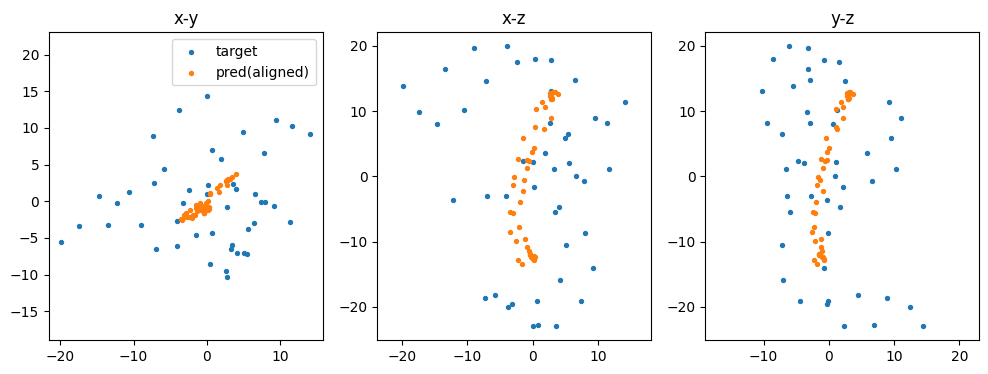

In [12]:
# ==========================================
# 10) Quick sanity check on holdout batch
#   - pick best head (min Kabsch RMSD) for sample 0
# ==========================================
import matplotlib.pyplot as plt

model.eval()
tokens_b, tgt_b, m_b = next(iter(hold_loader))
tokens_b = tokens_b.to(device)
tgt_b = tgt_b.to(device)
m_b = m_b.to(device)

with torch.no_grad():
    preds_b = model(tokens_b)  # (B,K,T,3)

# choose sample 0
preds0 = preds_b[0]   # (K,T,3)
tgt0 = tgt_b[0]       # (T,3)
mask0 = m_b[0]        # (T,)

# compute RMSD per head after Kabsch, pick best
rmsds = []
aligned = []
for k in range(preds0.size(0)):
    pk = preds0[k:k+1]  # (1,T,3)
    tk = tgt0.unsqueeze(0)
    mk = mask0.unsqueeze(0)
    pk_al = kabsch_align(pk, tk, mk)[0].detach().cpu()
    aligned.append(pk_al)
    diff_sq = (pk_al - tgt0.detach().cpu())**2
    sum_sq = (diff_sq * mask0.detach().cpu().unsqueeze(-1)).sum()
    n_valid = (mask0.detach().cpu().sum() * 3).clamp_min(1.0)
    rmsd = torch.sqrt(sum_sq / n_valid + 1e-8).item()
    rmsds.append(rmsd)

best_k = int(np.argmin(rmsds))
pred_best = aligned[best_k].numpy()
tgt_np = tgt0.detach().cpu().numpy()
mask_np = mask0.detach().cpu().numpy().astype(bool)

print("best_k:", best_k, "RMSD:", rmsds[best_k])

# 2D projections (xy, xz, yz)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pairs = [(0,1,"x-y"), (0,2,"x-z"), (1,2,"y-z")]
for ax,(i,j,title) in zip(axes, pairs):
    ax.scatter(tgt_np[mask_np, i], tgt_np[mask_np, j], s=8, label="target")
    ax.scatter(pred_best[mask_np, i], pred_best[mask_np, j], s=8, label="pred(aligned)")
    ax.set_title(title)
    ax.axis("equal")
axes[0].legend()
plt.show()

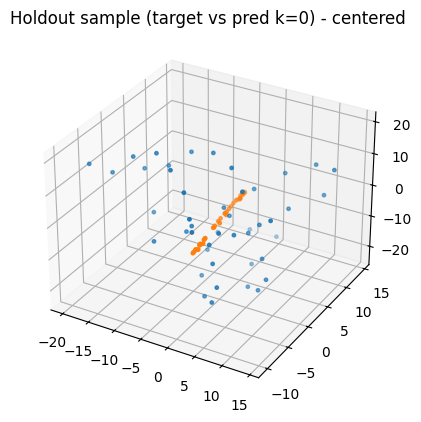

In [13]:
# ==========================================
# 10) Quick visualization on holdout batch (k=0)
# ==========================================
import matplotlib.pyplot as plt

model.eval()
tokens_b, tgt_b, m_b = next(iter(hold_loader))
tokens_b = tokens_b.to(device)
tgt_b = tgt_b.to(device)
m_b = m_b.to(device)

with torch.no_grad():
    preds_b = model(tokens_b)  # (B,K,T,3)
pred0 = preds_b[0,0].detach().cpu().numpy()
tgt0  = tgt_b[0].detach().cpu().numpy()
m0    = m_b[0].detach().cpu().numpy().astype(bool)

pred0 = pred0[m0]
tgt0  = tgt0[m0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(tgt0[:,0], tgt0[:,1], tgt0[:,2], s=6)
ax.scatter(pred0[:,0], pred0[:,1], pred0[:,2], s=6)
ax.set_title("Holdout sample (target vs pred k=0) - centered")
plt.show()